In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer,GradientDescentOptimizer

In [3]:
dev = qml.device("default.qubit", wires=8)

In [4]:
def amplitude_encoding(x, wires):
  qml.AmplitudeEmbedding(features=x, wires=wires, normalize=True)

def amplitude_encoding_inverse(x, wires):
  qml.adjoint(qml.AmplitudeEmbedding)(features=x, wires=wires, normalize=True)

In [5]:
def qaoa_ansatz(number_qubit,start_wire, theta):
  '''
  theta_size = 2n
  start_wires = 0 or 4
  '''

  for i in range(number_qubit):
    qml.H(wires=[i+start_wire])
    qml.RY(theta[i], wires=[i+start_wire])
  for i in range(number_qubit):
    c = i
    if c == number_qubit-1:
      f = number_qubit-1
      c = 0
    else:
      f = c+1
    qml.CNOT(wires=[c+start_wire,f+start_wire])
    qml.RZ(theta[number_qubit+i], wires=[f+start_wire])
    qml.CNOT(wires=[c+start_wire,f+start_wire])
print(qml.draw(qaoa_ansatz)(4,0, [1,2,3,4,5,6,7,8]))


0: ──H──RY(1.00)─╭●───────────╭●─────────────────────────────────╭●───────────╭●─┤  
1: ──H──RY(2.00)─╰X──RZ(5.00)─╰X─╭●───────────╭●─────────────────│────────────│──┤  
2: ──H──RY(3.00)─────────────────╰X──RZ(6.00)─╰X─╭●───────────╭●─│────────────│──┤  
3: ──H──RY(4.00)─────────────────────────────────╰X──RZ(7.00)─╰X─╰X──RZ(8.00)─╰X─┤  


In [6]:
def hardware_effificent_ansatz(number_qubit, theta):
  '''
  theta_size = 2n
  '''
  for i in range(number_qubit):
    qml.H(wires=[i])
    qml.RY(theta[i], wires=[i])
  for i in range(number_qubit):
    c = i
    if c == number_qubit-1:
      f = 0
    else:
      f = c+1
    qml.CRY(theta[number_qubit+i], wires=[c,f])
print(qml.draw(hardware_effificent_ansatz)(4, [1,2,3,4,5,6,7,8]))

0: ──H──RY(1.00)─╭●────────────────────────────╭RY(8.00)─┤  
1: ──H──RY(2.00)─╰RY(5.00)─╭●──────────────────│─────────┤  
2: ──H──RY(3.00)───────────╰RY(6.00)─╭●────────│─────────┤  
3: ──H──RY(4.00)─────────────────────╰RY(7.00)─╰●────────┤  


In [7]:
@qml.qnode(dev)
def full_circuit(x, weights):
  '''
  x: input
  weights: [theta1, theta2, theta3, theta4]
  '''
  # step 1: initial state
  # step 2: compute QKSAS
  # first register
  amplitude_encoding(x=x, wires=range(4))
  qaoa_ansatz(number_qubit=4,start_wire=0, theta=weights[0])
  # hardware_effificent_ansatz(number_qubit=3, theta=weights[0])  
  amplitude_encoding_inverse(x=x, wires=range(4))
  # qml.adjoint(hardware_effificent_ansatz)(number_qubit=3, theta=weights[1])
  qml.adjoint(qaoa_ansatz)(number_qubit=4,start_wire=0, theta=weights[1])

  # second register
  amplitude_encoding(x=x, wires=range(4,8))
  qaoa_ansatz(number_qubit=4,start_wire=3, theta=weights[2])

  # step 3: apply DMP
  # measure M1
  m_10 = qml.measure(0)
  m_11 = qml.measure(1)
  m_12 = qml.measure(2)
  m_13 = qml.measure(3)  

  # conditional with wires 4->7, theta4
  qml.cond(m_10, qml.RY)(weights[3][0], wires=4)
  qml.cond(m_11, qml.RY)(weights[3][1], wires=5)
  qml.cond(m_12, qml.RY)(weights[3][2], wires=6)
  qml.cond(m_13, qml.RY)(weights[3][3], wires=7)

  # step 4: measure M2 and return
  return qml.expval(qml.PauliZ(4) @ qml.PauliZ(5) @ qml.PauliZ(6) @ qml.PauliZ(7))

In [8]:
weights = 0.1 * np.random.randn(4, 8, requires_grad=True)
params = (weights,)

In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(*args, **kwargs):
    # Extract the parameters and data from *args and **kwargs
    weights = args[0]  # Assuming the first argument is the parameters (usually a NumPy array)
    X = kwargs.get('X', None)  # Get X from kwargs, default to None if not provided
    Y = kwargs.get('Y', None)  # Get Y from kwargs, default to None if not provided

    predictions = [full_circuit(x=x, weights=weights) for x in X]
    return np.mean((Y - qml.math.stack(predictions)) ** 2)

In [10]:
#******************************************
# Data import
#******************************************

# import train, dev and test datasets: the data entries are all strings of the form 'label sentence' 
# with the label in {0,1} and with the sentence of the form "word1_POStag1 word2_POStag2 ..."

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_train_data.txt') as f:
    training_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_dev_data.txt') as f:
    dev_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_test_data.txt') as f:
    testing_data_raw = f.readlines()
#***************************************************************
# Turn the raw input data into data structures convenient below
#***************************************************************

vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data = []       # list of sentences in the test dataset as strings "word1 word2 ..."
training_data_label = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data_label = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data_label = []
# Go through the train data
for sent in training_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    training_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    training_data_label.append(label)

# Go through the dev data
for sent in dev_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    dev_data_label.append(label)
    
# Go through the test data
for sent in testing_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    testing_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    testing_data_label.append(label)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

def embedding_sentece(data_list):
    sentences = data_list
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)  
    word_index = tokenizer.word_index  
    vocab_size = len(word_index) + 1  # Số lượng từ vựng (+1 cho padding)
    sequences = tokenizer.texts_to_sequences(sentences)

    max_length = max(len(seq) for seq in sequences)  # Độ dài tối đa
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    
    embedding_dim = 4  # Chọn số chiều của vector embedding
    
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
    ])
    
    output = model.predict(padded_sequences)
    return output
X = np.array(embedding_sentece(training_data), dtype='float64')
Y = np.array(training_data_label)
X_dev = np.array(embedding_sentece(dev_data), dtype='float64')
Y_dev = np.array(dev_data_label)
X_test = np.array(embedding_sentece(testing_data), dtype='float64')
Y_test = np.array(testing_data_label)
X = X.reshape(-1,16)
X_dev = X_dev.reshape(-1,16)
X_test = X_test.reshape(-1,16)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [11]:
print(X.shape)
print(Y.shape)

(70, 16)
(70,)


In [12]:
X_batch = X
Y_batch = Y
X_test_batch = X_dev
Y_test_batch = Y_dev

In [13]:
print(len(X))
print(len(Y))
print(len(X_dev))
print(len(Y_dev))
print(len(X_test))
print(len(Y_test))

70
70
30
30
30
30


In [14]:
import matplotlib.pyplot as plt
def draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers=1):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    axs[0].plot(epoch, current_cost_list,label=f'loss_{lrate}')
    axs[0].set_title(f'Loss {n_layers}')
    axs[0].set_xlabel('Epoch')  # Set x-axis label
    axs[0].set_ylabel('Cost Function')  # Set y-axis label
    axs[0].legend()
    axs[1].plot(epoch, acc_list, label=f'train_acc_{lrate}')
    axs[1].set_title(f'Train acc {n_layers}')
    axs[1].set_xlabel('Epoch')  # Set x-axis label
    axs[1].set_ylabel('Train Accuraccy')  # Set y-axis label
    axs[1].legend()
    axs[2].plot(epoch, test_acc_list,label=f'test_acc_{lrate}')
    axs[2].set_title(f'Test acc {n_layers}')
    axs[2].set_xlabel('Epoch')  # Set x-axis label
    axs[2].set_ylabel('Test Accuraccy')  # Set y-axis label
    axs[2].legend()
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"/kaggle/working/chart_nlayer{n_layers}_lrate{lrate}.png")

Iter:    1 | Cost: 1.2342875 | Accuracy: 0.4428571 | Test Accuracy: 0.5333333 | Run Time: 19.3522592
Iter:    2 | Cost: 1.1990694 | Accuracy: 0.4714286 | Test Accuracy: 0.5666667 | Run Time: 18.6579585
Iter:    3 | Cost: 1.1299913 | Accuracy: 0.4714286 | Test Accuracy: 0.6333333 | Run Time: 20.0301011
Iter:    4 | Cost: 1.0246550 | Accuracy: 0.5285714 | Test Accuracy: 0.6333333 | Run Time: 19.0194719
Iter:    5 | Cost: 0.9119527 | Accuracy: 0.6142857 | Test Accuracy: 0.5333333 | Run Time: 18.9864800
Iter:    6 | Cost: 0.8376416 | Accuracy: 0.6857143 | Test Accuracy: 0.4666667 | Run Time: 18.8268805
Iter:    7 | Cost: 0.8215344 | Accuracy: 0.7428571 | Test Accuracy: 0.5666667 | Run Time: 18.7477651
Iter:    8 | Cost: 0.8290343 | Accuracy: 0.7000000 | Test Accuracy: 0.6000000 | Run Time: 18.4827785
Iter:    9 | Cost: 0.8335174 | Accuracy: 0.6714286 | Test Accuracy: 0.6000000 | Run Time: 19.2621691
Iter:   10 | Cost: 0.8322539 | Accuracy: 0.6857143 | Test Accuracy: 0.6000000 | Run Time: 1

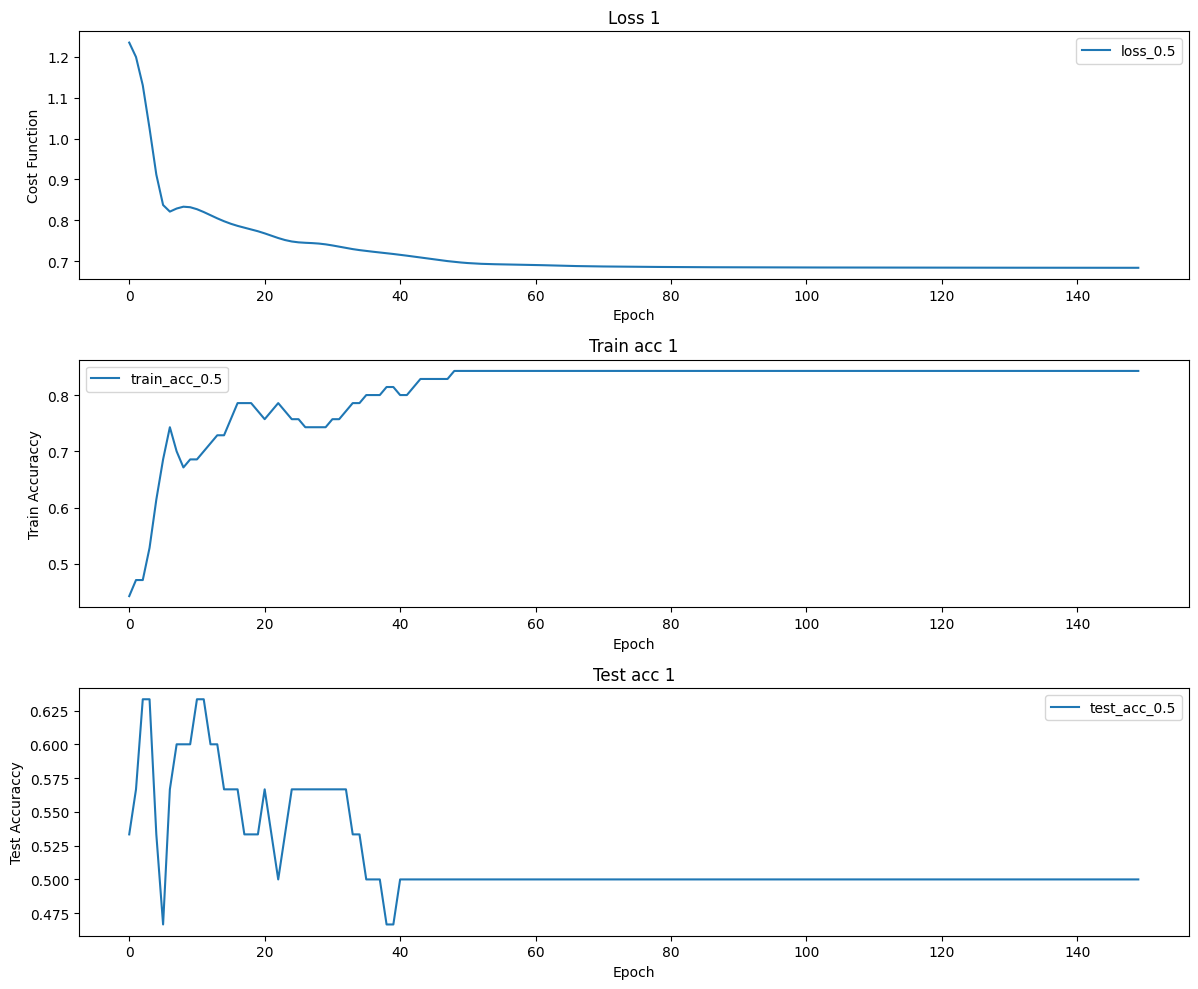

[[-1.23672813e+00 -8.67001805e-01  9.31304697e-01 -2.03039770e-01
   6.43974558e-01  2.05366525e-01  3.65068991e-01 -1.11216709e-01]
 [-9.73088084e-01 -1.09002086e+00  1.07399221e+00  8.79083732e-01
  -3.39353882e-01  2.32974634e-01 -1.40492078e-01 -7.89312051e-01]
 [-9.40620221e-01  1.55156677e+00 -1.55046343e+00 -1.89484520e+00
   2.40103750e-02 -4.97646671e-03 -1.25421834e-04  1.81181644e-04]
 [ 3.03160117e-01  6.12443778e-01  1.12753372e+00 -9.69348113e-01
   1.77854557e-01 -2.22511754e-02 -1.60783712e-04 -4.23248383e-02]]


In [15]:
import time
learning_rate = [0.5]
num_layers = [1]
for n_layers in num_layers:
    lrate = 0.5

    opt = NesterovMomentumOptimizer(lrate)
    current_cost_list = []
    acc_list = []
    test_acc_list = []
    epoch = []
    for it in range(150):
        start_time = time.time()

        # Update the weights by one optimizer step, using only a limited batch of data
        gradient_value, current_cost = opt.compute_grad(objective_fn=cost, args=params, kwargs={"X": X, "Y": Y})
        params = opt.apply_grad(grad=gradient_value, args=params)
        current_cost_list.append(current_cost)
        weights = params[0]
        # Compute accuracy on train
        predictions = [np.sign(full_circuit(x,weights)) for x in X]
        acc = accuracy(Y, predictions)
        acc_list.append(acc)

        # Compute accuracy on test
        predictions_test = [np.sign(full_circuit(x,weights,)) for x in X_dev]
        test_acc = accuracy(Y_dev, predictions)
        test_acc_list.append(test_acc)
        epoch.append(it)

        # Redraw the updated plot
        end_time = time.time() - start_time
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f} | Test Accuracy: {test_acc:0.7f} | Run Time: {end_time:0.7f}")
    draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers)
    print(weights)

In [16]:
# Compute accuracy
weights = params[0]
predictions = [np.sign(full_circuit(x,weights)) for x in X_test]
acc = accuracy(Y_test, predictions)
print(f"Final test, accuracy_test: {acc}")

Final test, accuracy_test: 0.6
